In [15]:
# Install dependencies
!pip install -q transformers datasets evaluate scikit-learn accelerate

import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
# Load GoEmotions dataset (simplified version usually contains train/val/test splits)
dataset = load_dataset("google-research-datasets/go_emotions", "simplified")

# Inspect the dataset structure
print(dataset)
print(f"Labels: {dataset['train'].features['labels'].feature.names}")

# Configuration
LABELS = dataset['train'].features['labels'].feature.names
NUM_LABELS = len(LABELS)

# Analysis: Check distribution of first 5 samples
for i in range(5):
    print(f"Text: {dataset['train'][i]['text']}")
    print(f"Labels: {[LABELS[l] for l in dataset['train'][i]['labels']]}")
    print("-" * 30)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})
Labels: ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']
Text: My favourite food is anything I didn't have to cook myself.
Labels: ['neutral']
------------------------------
Text: Now if he does off himself, everyone will think hes having a laugh screwing with people instead of actually dead
Labels: ['neutral']
------------------------------
Text: WHY THE FUCK IS BAYLESS ISOING
Labels: ['anger']
---------

In [17]:
import numpy as np

# Model Checkpoint
MODEL_CKPT = "huawei-noah/TinyBERT_General_4L_312D"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def preprocess_data(examples):
    # Tokenize text
    encoding = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

    # Create multi-label targets (k-hot encoding)
    # FORCE dtype to float32 here
    labels_matrix = np.zeros((len(examples["labels"]), NUM_LABELS), dtype=np.float32)

    # Fill ones for active labels
    for idx, label_indices in enumerate(examples["labels"]):
        labels_matrix[idx, label_indices] = 1.0

    encoding["labels"] = labels_matrix.tolist()
    return encoding

# Apply preprocessing
# crucial: ensure remove_columns gets rid of the original integer labels
encoded_dataset = dataset.map(
    preprocess_data,
    batched=True,
    remove_columns=dataset['train'].column_names
)

# Set format to torch, explicitly creating FloatTensors
encoded_dataset.set_format("torch")

# VERIFICATION: Run this small check to ensure labels are now float32
print(f"Label Dtype: {encoded_dataset['train'][0]['labels'].dtype}")
# Expected output: torch.float32

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Label Dtype: torch.int64


In [18]:
def multi_label_metrics(predictions, labels, threshold=0.5):
    # Apply sigmoid to logits
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.tensor(predictions))

    # Convert probabilities to binary predictions
    y_pred = np.zeros(probs.shape)
    y_pred[probs >= threshold] = 1

    y_true = labels

    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    accuracy = accuracy_score(y_true, y_pred)

    return {
        'accuracy': accuracy,
        'f1_micro': f1_micro_average,
        'f1_macro': f1_macro_average
    }

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    return multi_label_metrics(predictions=preds, labels=p.label_ids)

In [20]:
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=NUM_LABELS,
    problem_type="multi_label_classification"
)
model.to(device)

# 2. Define a Robust Data Collator
# This function runs for every batch and guarantees labels are Float32
def data_collator(features):
    # Use tokenizer to pad input_ids and attention_mask
    batch = tokenizer.pad(features, padding=True, return_tensors="pt")

    # EXPLICITLY cast labels to Float32 to satisfy BCEWithLogitsLoss
    if "labels" in batch:
        batch["labels"] = batch["labels"].float()

    return batch

# 3. Training Arguments (Updated for 2025/2026 API)
batch_size = 16
metric_name = "f1_micro"

args = TrainingArguments(
    output_dir="tinybert-finetuned-goemotions",
    eval_strategy="epoch",       # Corrected parameter name
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=4,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    fp16=True,                   # Keep mixed precision
    report_to="none"
)

# 4. Initialize Trainer with the Custom Collator
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    processing_class=tokenizer,  # Fixes the "tokenizer is deprecated" warning
    compute_metrics=compute_metrics,
    data_collator=data_collator  # <--- The Critical Fix
)

# Start training
print("Starting training with explicit Float32 labels...")
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Starting training with explicit Float32 labels...


Epoch,Training Loss,Validation Loss,Accuracy,F1 Micro,F1 Macro
1,0.148400,0.145061,0.000000,0.000000,0.000000
2,0.136300,0.131750,0.173240,0.257294,0.021891
3,0.123600,0.123956,0.200147,0.305804,0.053516
4,0.122100,0.121468,0.223922,0.329773,0.054952


TrainOutput(global_step=10856, training_loss=0.14199765429570557, metrics={'train_runtime': 315.8621, 'train_samples_per_second': 549.734, 'train_steps_per_second': 34.369, 'total_flos': 623541073305600.0, 'train_loss': 0.14199765429570557, 'epoch': 4.0})

Test Results: {'eval_loss': 0.12044598162174225, 'eval_accuracy': 0.22535470794177262, 'eval_f1_micro': 0.3371276338096391, 'eval_f1_macro': 0.055465656068129816, 'eval_runtime': 8.789, 'eval_samples_per_second': 617.474, 'eval_steps_per_second': 38.685, 'epoch': 4.0}


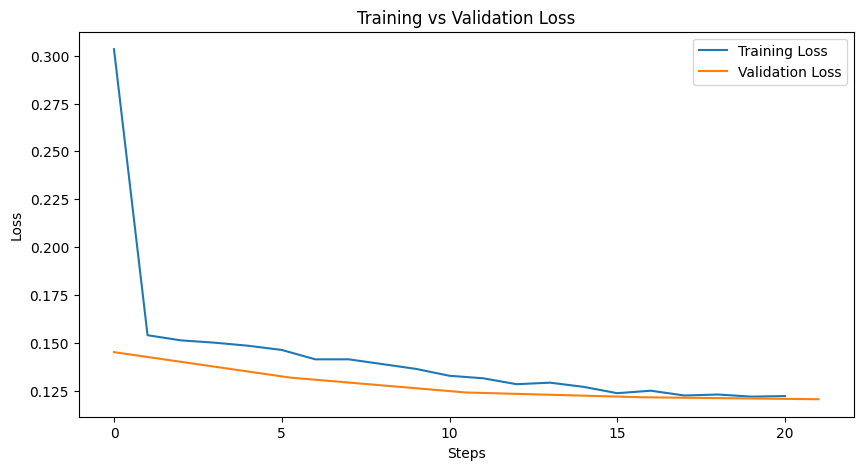

In [21]:
# Evaluate on Test Set
eval_results = trainer.evaluate(encoded_dataset["test"])
print(f"Test Results: {eval_results}")

# Plot Training History
history = trainer.state.log_history
loss_train = [x['loss'] for x in history if 'loss' in x]
loss_eval = [x['eval_loss'] for x in history if 'eval_loss' in x]

plt.figure(figsize=(10, 5))
plt.plot(loss_train, label='Training Loss')
plt.plot(np.linspace(0, len(loss_train), len(loss_eval)), loss_eval, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [22]:
def predict_emotion(text, threshold=0.5):
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128).to(device)

    # Inference
    with torch.no_grad():
        logits = model(**inputs).logits

    # Post-process
    probs = torch.sigmoid(logits).cpu().numpy()[0]
    predictions = (probs >= threshold).astype(int)

    # Map back to labels
    predicted_labels = [LABELS[idx] for idx, val in enumerate(predictions) if val == 1]

    return predicted_labels, probs

# Test
text_sample = "I am so happy that I passed the exam with flying colors!"
labels, probabilities = predict_emotion(text_sample)

print(f"Input: {text_sample}")
print(f"Predicted Emotions: {labels}")

Input: I am so happy that I passed the exam with flying colors!
Predicted Emotions: []


In [23]:
# Test dengan Debugging
text_sample = "I am so happy that I passed the exam with flying colors!"

# 1. Coba turunkan threshold ke 0.3 (atau lebih rendah)
labels, probabilities = predict_emotion(text_sample, threshold=0.25)

print(f"Input: {text_sample}")
print(f"Predicted Emotions (Threshold 0.25): {labels}")

# 2. Intip Top 3 prediksi teratas (meskipun probabilitasnya kecil)
# Ini penting untuk melihat apakah model sebenarnya "mulai paham" tapi kurang pede
top_inds = probabilities.argsort()[::-1][:3]
print("\nTop 3 Raw Probabilities:")
for idx in top_inds:
    print(f"{LABELS[idx]}: {probabilities[idx]:.4f}")

Input: I am so happy that I passed the exam with flying colors!
Predicted Emotions (Threshold 0.25): ['admiration']

Top 3 Raw Probabilities:
admiration: 0.3087
love: 0.1998
joy: 0.1657
